# Predictive clustering

In [1]:
import numpy as np
import pandas as pd
import math
import json
import os
from numba import jit, njit, prange
from tqdm import tqdm
from dbscan1d.core import DBSCAN1D
import matplotlib.pyplot as plt

In [2]:
# загрузим построенную нами обучающую выборку
train_pat = np.load('train_pat_1000_wishart_totlist3.npy')
print (train_pat.shape)
print (type(train_pat) , train_pat.nbytes/10e+8)

# Загрузим список наблюдений для тестовой выборки
new_test_tot3 = np.load('new_test_tot3.npy')
print(new_test_tot3.shape)

(1000, 2441, 5)
<class 'numpy.ndarray'> 0.09764
(64, 5)


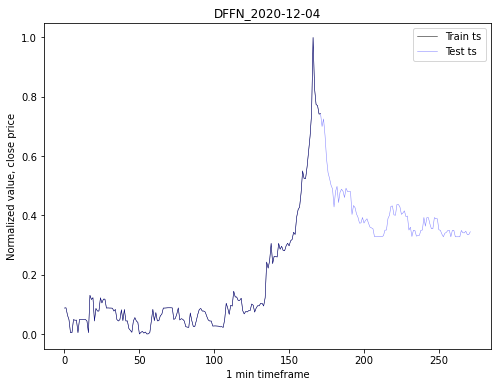

In [32]:
# тестовые сэмплы
k = [28,10,63,59,56,17,5]
n = [195,152,175,175,240,475,345]

item = new_test_tot3[59]
name = item[0]
date = item[1]
parent_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/train3'
ts = pd.read_csv(os.path.join(parent_dir, name + '_' + date + '.csv')).to_numpy().ravel()
min_ts = -0.9274193548387099
ts_diff = np.diff(ts)
ts_diff = ts_diff - np.full((ts_diff.shape[0], ), min_ts)

x1 = 172
x2 = x1+100

train_data = ts_diff[:x1].tolist()
test_data = ts_diff[x1:x2].tolist()

plt.figure(figsize=(8, 6))
plt.title(str(name) + '_' + str(date))
plt.plot(ts[:x1], color = 'black', linewidth=0.5, label='Train ts');
plt.plot(ts[:x2], color = 'blue', alpha=0.5, linewidth=0.5, label='Test ts');
plt.xlabel('1 min timeframe')
plt.ylabel('Normalized value, close price')
plt.legend()
plt.show()

In [5]:
N = np.array([0.6666], dtype=np.float32)
K = np.array([0.7777], dtype=np.float32)
train_vec = train_pat[:,:,:-1]

print(train_vec.shape)
patterns = np.load('patterns_1000_patterns_for_wishart.npy')
patterns

(1000, 2441, 4)


array([[ 3,  7,  6,  7],
       [ 1,  5,  5,  6],
       [10,  6,  1,  6],
       ...,
       [ 3,  7,  5,  8],
       [ 1,  5,  4, 10],
       [ 9,  5,  1,  5]], dtype=uint8)

In [6]:
@njit(parallel=True)
def last_vec(patterns,train_data):
    f_arr = np.zeros((patterns.shape[0],4), dtype=np.float32)
    for i in prange(patterns.shape[0]):
        c_ = (train_data.shape[0] - np.cumsum(patterns[i][::-1])).astype(np.int64)
        a1 = train_data[c_[0]]
        a2 = train_data[c_[1]]
        a3 = train_data[c_[2]]
        a4 = train_data[c_[3]]
        f_arr[i] = np.array([a4,a3,a2,a1],dtype=np.float32)
        if np.any(f_arr[i] == K[0]):
            f_arr[i] = 2*np.ones((4,), dtype=np.float32)
    return f_arr

In [7]:
@jit(nopython=True, fastmath=True)
def euclidean(u, v):
    n = len(u)
    dist = 0
    for i in prange(n):
        dist += abs(u[i] - v[i]) ** 2 
    return dist ** (1 / 2)

In [8]:
@njit(parallel=True)
def vec_distance(train_vec,f_arr,eps):
    n, m = train_vec.shape[0], train_vec.shape[1]
    dist=np.zeros((n, m), dtype=np.float32)
    for i in prange(n):
        for j in prange(m):
            if (train_vec[i,j][0]!=N):
                dist[i,j] = euclidean(f_arr[i], train_vec[i,j])
            else:
                dist[i,j] = 2
    return dist

In [9]:
@njit(parallel=True)
def forcast_sets(dist, train_pat, eps):
    f_vecs = (dist<eps).nonzero()
    result = np.vstack((f_vecs[0],f_vecs[1])).T
    k = result.shape[0]
    forcast_set = np.zeros((k, 1), dtype=np.float32)
    weights = np.zeros((k, 1), dtype=np.float32)
    for i in prange(k):
        forcast_set[i]=train_pat[result[i,0],result[i,1],4]
        weights[i]=1-dist[result[i,0],result[i,1]]/eps
    return forcast_set, weights

In [10]:
def clustering_pipeline(train_data, train_pat, train_vec, patterns, eps, eps_dbscan, K, S_max, steps):
    train_data_all=np.array([train_data])
    weights_all = np.array([1], dtype=np.float32)

    for i in tqdm(range(steps)):
        trs = []
        wts = []
 
        for train_tr, train_wt in zip(train_data_all, weights_all):
            f_arr = last_vec(patterns,train_tr)
            dist = vec_distance(train_vec,f_arr, eps)
            forcast_set, weights = forcast_sets(dist, train_pat, eps)
            if forcast_set.size == 0:
                f_mean_1 = f_mean_2 = K[0]          
                mean_weight_1 = mean_weight_2 = 0.00001
                
            else:    
                f_mean_1, f_mean_2, mean_weight_1, mean_weight_2 = dbs_mean_cpu_tr(forcast_set, weights, eps_dbscan, K)
                
            train_data_1 = np.hstack((train_tr, f_mean_1))
            train_data_2 = np.hstack((train_tr, f_mean_2))
            train_data_12 = np.vstack((train_data_1, train_data_2))
            trs.append(train_data_12)
            
            weights_1 = np.hstack((train_wt, mean_weight_1))
            weights_2 = np.hstack((train_wt, mean_weight_2))
            weights_12 = np.vstack((weights_1, weights_2))
            wts.append(weights_12)
            
        train_data_all = np.vstack(trs)
        weights_all = np.vstack(wts)
        
        if weights_all.shape[0] > S_max:
            traj_wts = np.prod(weights_all,1)
            pct = np.sort(traj_wts)[::-1][S_max-1]
            cut_traj_weights = np.where(traj_wts>=pct)
            train_data_all = train_data_all[cut_traj_weights[0]]
            weights_all = weights_all[cut_traj_weights[0]]

    return train_data_all[:, -steps:]

In [43]:
def dbs_mean_cpu_tr(forcast_set, weights, eps_dbscan, K):    
    db = DBSCAN1D(eps=eps_dbscan, min_samples=3).fit(forcast_set)
    labels = db.labels_
    clusters_all = np.stack(np.unique(labels, return_counts = True),1)
    clusters_wn = clusters_all[clusters_all[:,0]>-1]

    if clusters_wn.shape[0] == 0:
        f_mean_1 = f_mean_2 = K[0]
        mean_weight_1 = mean_weight_2 = 0.00001
    elif clusters_wn[:,1].size == 1:
        f_mean_1 = f_mean_2 = np.mean(forcast_set[np.where(labels == 0)])
        mean_weight_1 = mean_weight_2 = np.mean(weights[np.where(labels == 0)])
    else:
        sorted_labels = np.argsort(clusters_wn[:,1], axis=0)
        first_cl = clusters_wn[:,0][sorted_labels[-1]]
        second_cl = clusters_wn[:,0][sorted_labels[-2]]
        
        if clusters_wn[first_cl,1] > 0.20*np.sum(clusters_wn[:,1]):
            f_mean_1 = np.mean(forcast_set[np.where(labels == first_cl)])
            f_mean_2 = np.mean(forcast_set[np.where(labels == second_cl)])
            mean_weight_1 = np.mean(weights[np.where(labels == first_cl)])
            mean_weight_2 = np.mean(weights[np.where(labels == second_cl)])
        else:
            f_mean_1 = f_mean_2 = K[0]
            mean_weight_1 = mean_weight_2 = 0.00001

    return f_mean_1, f_mean_2, mean_weight_1, mean_weight_2

In [95]:
steps = 100
S_max = 5
eps = 0.02
eps_dbscan = 0.002
K = np.array([0.0777], dtype=np.float32)
frct_cl_tr = clustering_pipeline(train_data, train_pat, train_vec, patterns, eps, eps_dbscan, K, S_max, steps)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


In [77]:
#np.save('frct_cl_tr_59.npy',frct_cl_tr)
#frct_cl_tr = np.load('frct_cl_tr_59.npy')

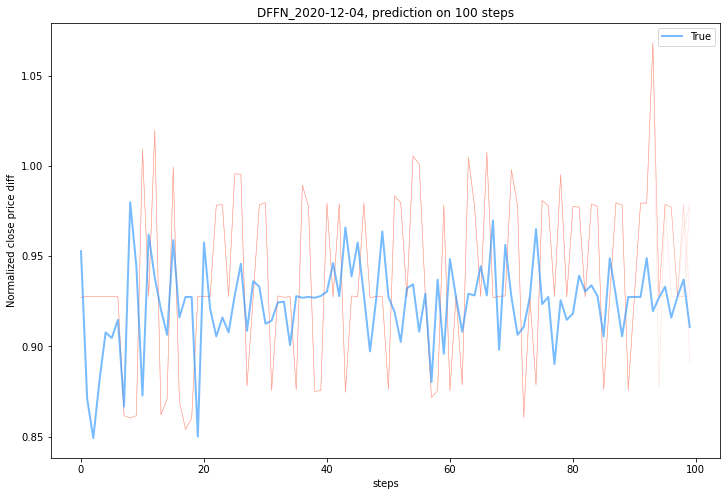

In [96]:
plt.figure(figsize=(12, 8))
plt.title(str(name) + '_' + str(date) + ', prediction on 100 steps')
for i in range(len(frct_cl_tr)):
    plt.plot(frct_cl_tr[i], color='tomato', lw=0.5, alpha =0.2)
plt.plot(ts_diff[x1:x2], label='True', color='dodgerblue', lw=2, alpha =0.6)
plt.xlabel('steps')
plt.ylabel('Normalized close price diff')
plt.legend()
plt.show()

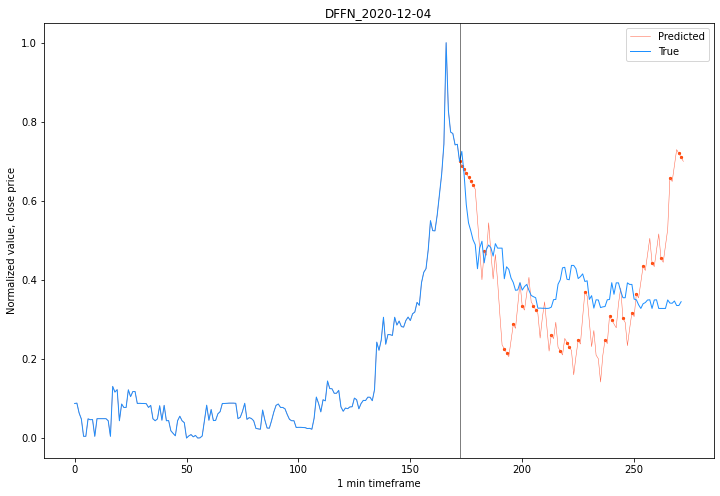

In [97]:
ts_diff_1 = np.round(frct_cl_tr[0],4)
non_preds =[]
preds =[]
for i in range(len(ts_diff_1)):
    if 0.9271<=ts_diff_1[i]<=0.9278:
        non_preds.append(i+x1)
    else:
        preds.append(i+x1)

inv_ts1 = [ts[x1]]
new_val1 = ts[x1]
for i in range(len(ts_diff[x1:x2])):
    new_val1 += + ts_diff[x1:x2][i] + min_ts
    inv_ts1.append(new_val1)

inv_ts2 = [ts[x1]]
new_val2 = ts[x1]
for i in range(len(frct_cl_tr[0])):
    new_val2 += frct_cl_tr[0][i] - np.mean(frct_cl_tr[0])
    inv_ts2.append(new_val2)

plt.figure(figsize=(12, 8))
plt.title(str(name) + '_' + str(date))
for i in np.arange(x1,x2):
    if i in non_preds:
        plt.scatter(i, inv_ts2[i-x1], color='orangered', marker ='.', s=20)
plt.plot(ts[:x1].tolist() + inv_ts2, linewidth=0.5, label='Predicted', color='tomato')        
plt.plot(ts[:x1].tolist() + ts[x1:x2].tolist(), linewidth=1, label='True', color='dodgerblue')
plt.axvline(x=x1, linewidth=0.5, color='black')
plt.xlabel('1 min timeframe')
plt.ylabel('Normalized value, close price')
plt.legend()
plt.show()